In [1]:
import pandas as pd
import seaborn as sns
import igraph
import numpy as np
import matplotlib.pyplot as plt
from genderize import Genderize
from IPython.display import Image
import json
from urllib.request import urlopen
from urllib.parse import quote

%matplotlib inline

## Load data

In [43]:
outfile = "../data/img/init_coa_graph.png"
new_plot = True
g = igraph.load('../data/florida_coa_graph',format='pickle')
buy_names = False # if this is true, and you run the notebook, it will use all your gender api credits

#Here is how to map for to get authors / papers
method = 'florida'
a_2_node = np.load('%s/data/%s_a_2_node.npy'%('..',method),allow_pickle='TRUE').item()
a_2_paper = np.load('%s/data/%s_a_2_paper.npy'%('..',method),allow_pickle='TRUE').item()
node_2_a = np.load('%s/data/%s_node_2_a.npy'%('..',method),allow_pickle='TRUE').item()

# load gender api key (you'll need to make this txt file if you dont have one)
if buy_names:
    f = open("../data/genderAPI_key.txt", "r")
    genderAPI_key = f.readline().replace('\n', '')

In [3]:
g.summary()

'IGRAPH UN-- 151936 1492921 -- \n+ attr: name (v), year (e)'

In [4]:
# get list of nodes with 0 deg
#g.vs.select(_degree=0).delete() # if you want to delete them - but this changes the index and mapping to authors
disconnected_nodes = g.vs.select(_degree=0)

In [44]:
visual_style = {}

# Define colors used for outdegree visualization
colours = ['#fecc5c', '#a31a1c']

# Set bbox and margin
visual_style["bbox"] = (600,300)
visual_style["margin"] = 17

# Set vertex colours
visual_style["vertex_color"] = 'grey'

# Set vertex size
visual_style["vertex_size"] = 5

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# Don't curve the edges
visual_style["edge_curved"] = True

if new_plot:
    # Plot the graph
    igraph.plot(g, outfile, **visual_style)

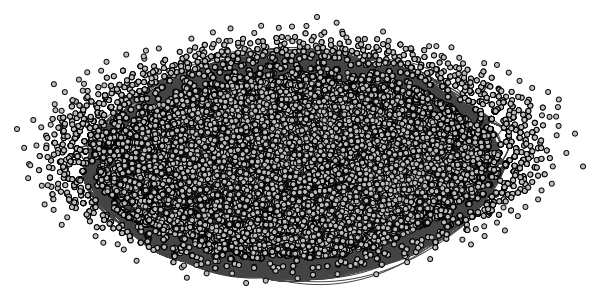

In [45]:
Image(filename=outfile) 

In [5]:
print("Number of vertices:", g.vcount())
print("Number of edges:", g.ecount())
print("Density of the graph:", 2*g.ecount()/(g.vcount()*(g.vcount()-1)))

Number of vertices: 151936
Number of edges: 1492921
Density of the graph: 0.00012934460053903355


In [6]:
degrees = []
total = 0

for n in range(g.vcount()):
    neighbours = g.neighbors(n, mode='ALL')
    total += len(neighbours)
    degrees.append(len(neighbours))
    
print("Average degree:", total/g.vcount())
print("Maximum degree:", max(degrees))
print("Author with the maximum degree:", node_2_a[degrees.index(max(degrees))])

Average degree: 19.651971882898064
Maximum degree: 1072
Author with the maximum degree: Geschwind, Daniel H.


Degree having the maximum number of vertices: 6
Number of vertices having the most abundant degree: 10551


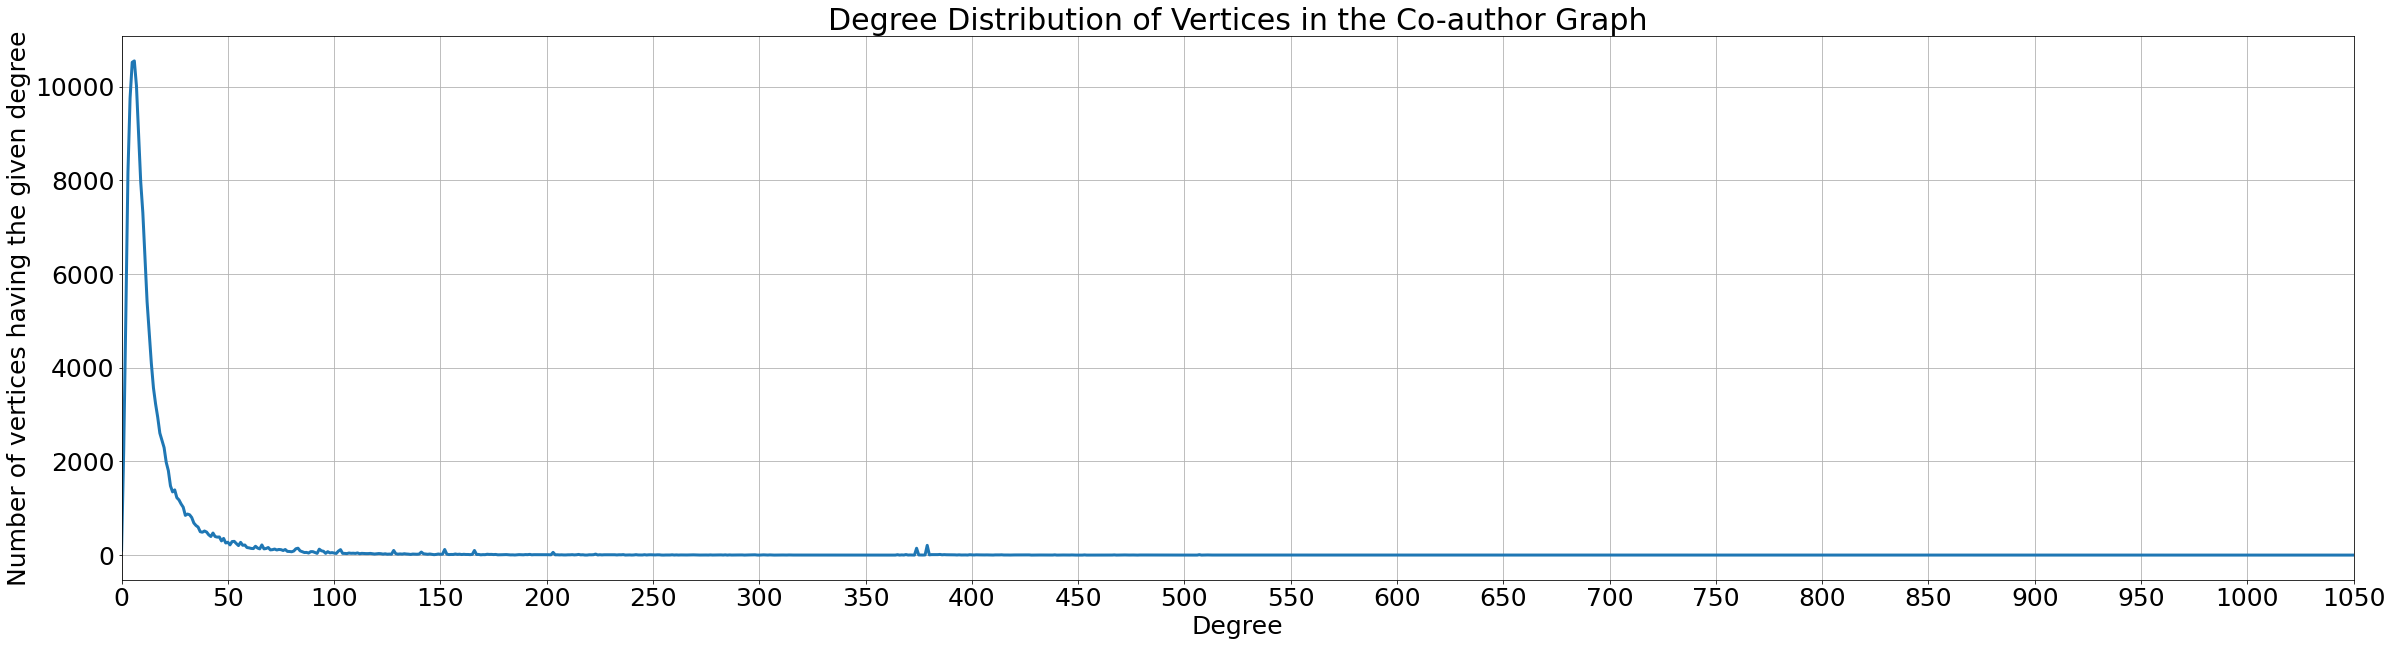

<Figure size 432x288 with 0 Axes>

In [7]:
plt.rcParams.update({'font.size': 25})

x = [x for x in range(max(degrees)+1)]
degree_counts = [0 for x in range(1073)]

for i in degrees:
    degree_counts[i] += 1

print("Degree having the maximum number of vertices:", degree_counts.index(max(degree_counts)))
print("Number of vertices having the most abundant degree:", max(degree_counts))

plt.figure(figsize=(40,10))
plt.plot(x, degree_counts, linewidth=3.0)
plt.ylabel('Number of vertices having the given degree')
plt.xlabel('Degree')
plt.title('Degree Distribution of Vertices in the Co-author Graph')

plt.xlim(0,100)
plt.xticks(np.arange(min(x), max(x)+1, 50.0))
plt.grid(True)
plt.show()
plt.draw()

In [94]:
g.summary()

'IGRAPH UN-- 151936 1492921 -- \n+ attr: name (v), year (e)'

## Get gender of names

In [9]:
# First, process the full name into a first name

# intialize
node_2_fname = dict.fromkeys(node_2_a.keys())

# loop through authors
for node in node_2_fname.keys():
    auth = node_2_a[node]
    auth = auth.replace('.', ' ')

    #splitting on space
    if (len(auth.split(', ')[-1].split()[0].strip(', ')) > 1):
        auth = auth.split(', ')[-1].split()[0].strip(', ')
    elif (np.size(auth.split(', ')[-1].split()) > 1):
        if (len(auth.split(', ')[-1].split()[1].strip(', ')) > 1):
            auth = auth.split(', ')[-1].split()[1].strip(', ')
        else:
            auth = ""
    else:
        auth = ""  # if there is something weird going on, just leave it blank 

    node_2_fname[node] = auth
            
    
np.save(f"../data/{method}_node_2_fname.npy",node_2_fname,allow_pickle='TRUE')

In [10]:
# now get the gender. this is the part that will use credits (about 28,000 are needed)

if buy_names:
    # initialize
    node_2_gender = dict.fromkeys(node_2_fname.keys())
    
    # loop through authors
    for node,idx in enumerate(node_2_gender.keys()):
        # check if this name has been found before, so we don't pay for it twice
        auth = node_2_fname[node]
        hits = [val == auth for val in node_2_fname.values()]
        dup = (sum(hits) > 1) & any(np.where(hits)[0] < idx)

        # get estimated gender
        if (auth != "") & (not(dup)):
            url = "https://gender-api.com/get?key=" + genderAPI_key + "&name=%s" %(quote(auth))
            response = urlopen(url)
            decoded = response.read().decode('utf-8')
            gender = json.loads(decoded)
            gender.pop('country')
            gender.pop('duration')
            gender.pop('credits_used')
            node_2_gender[node] = gender
        elif (auth != "") & (dup):
            # if its a duplicate, take the first instance of the name in the dictionary
            dup_key = [key  for (key, value) in node_2_fname.items() if value == auth]
            node_2_gender[node] = node_2_gender[dup_key[0]]
        elif auth == "":
            node_2_gender[node] = {"name":None,
                                  "name_sanitized":None,
                                  "gender":None,
                                  "accuracy":None,
                                  "samples":None}
    np.save(f"../data/{method}_node_2_gender.npy",node_2_gender,allow_pickle='TRUE')
else:
    node_2_gender = np.load('%s/data/%s_node_2_gender.npy'%('..',method),allow_pickle='TRUE').item()
            
    
node_2_gender

{0: {'name': 'andre',
  'name_sanitized': 'Andre',
  'gender': 'male',
  'samples': 49457,
  'accuracy': 97},
 1: {'name': 'gian',
  'name_sanitized': 'Gian',
  'gender': 'male',
  'samples': 4145,
  'accuracy': 97},
 2: {'name': 'marisol',
  'name_sanitized': 'Marisol',
  'gender': 'female',
  'samples': 14443,
  'accuracy': 99},
 3: {'name': 'edmar',
  'name_sanitized': 'Edmar',
  'gender': 'male',
  'samples': 904,
  'accuracy': 98},
 4: {'name': 'renata',
  'name_sanitized': 'Renata',
  'gender': 'female',
  'samples': 30340,
  'accuracy': 99},
 5: {'name': 'vinicius',
  'name_sanitized': 'Vinicius',
  'gender': 'male',
  'samples': 7882,
  'accuracy': 100},
 6: {'name': 'vitor',
  'name_sanitized': 'Vitor',
  'gender': 'male',
  'samples': 15338,
  'accuracy': 99},
 7: {'name': 'umbertina',
  'name_sanitized': 'Umbertina',
  'gender': 'female',
  'samples': 6,
  'accuracy': 100},
 8: {'name': 'andre',
  'name_sanitized': 'Andre',
  'gender': 'male',
  'samples': 49457,
  'accuracy

Number of Women: 54046 ( 35.57155644481887 %)
Number of Men: 87603 ( 57.657829612468404 %)
Number of Men: 2293 ( 1.5091880791912384 %)
Proportion W:M: 0.6169423421572321


/Users/stiso/anaconda2/envs/mod_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

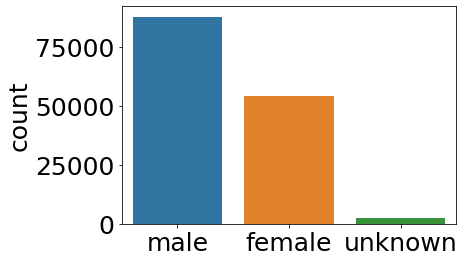

In [14]:
# Visualize number of female, male, and unknown names
gen = [x['gender'] for x in node_2_gender.values()]

print("Number of Women:", sum([x == 'female' for x in gen]), '(', sum([x == 'female' for x in gen])/len(gen)*100, '%)')
print("Number of Men:", sum([x == 'male' for x in gen]), '(', sum([x == 'male' for x in gen])/len(gen)*100, '%)')
print("Number of Unknown:", sum([x == 'unknown' for x in gen]), '(', sum([x == 'unknown' for x in gen])/len(gen)*100, '%)')
print("Proportion W:M:", sum([x == 'female' for x in gen])/sum([x == 'male' for x in gen]))

sns.countplot(gen, palette = ['#4a3b90', '#d97d5b', 'grey'])

In [18]:
# randomly assign gender to unknown people

m_thr = 0.58 # the percentage that are male

for auth in node_2_gender.keys():
    if node_2_gender[auth]['gender'] == 'unknown':
        n = np.random.uniform()
        if n < m_thr:
            node_2_gender[auth]['gender'] = 'male'
        else:
            node_2_gender[auth]['gender'] = 'female'

Number of Women: 54984 ( 36.18892165122157 %)
Number of Men: 88958 ( 58.549652485256956 %)
Number of Unknown: 0 ( 0.0 %)
Proportion W:M: 0.6180894354639268


/Users/stiso/anaconda2/envs/mod_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

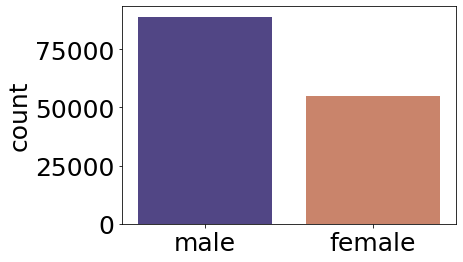

In [208]:
# Visualize number of female, male, and unknown names
gen = [x['gender'] for x in node_2_gender.values()]

print("Number of Women:", sum([x == 'female' for x in gen]), '(', sum([x == 'female' for x in gen])/len(gen)*100, '%)')
print("Number of Men:", sum([x == 'male' for x in gen]), '(', sum([x == 'male' for x in gen])/len(gen)*100, '%)')
print("Number of Unknown:", sum([x == 'unknown' for x in gen]), '(', sum([x == 'unknown' for x in gen])/len(gen)*100, '%)')
print("Proportion W:M:", sum([x == 'female' for x in gen])/sum([x == 'male' for x in gen]))

sns.countplot(gen, palette = ['#4a3b90', '#d97d5b'])

# Classes and functions for simulations

In [188]:
class Author:
    def __init__(self, network_bias:float, beta:float, meet_bias:float, walk_bias:float, gender='F'):
        '''
        Inputs:
            gender          string, 'M' or 'F'
            beta            a scalar float. Determines how this author learns from others
            meet_bias       a scalar float. Determines how similar a strangers network has to 
                            be to meet with them
            network_bias    a scalar float. Determines how much their estimated social notwork 
                            is biased towards people with the same gender. 0 indicates all men 
                            will be chosen, and 1 indicates all women will be chosem
            walk_bias       a scalar floar. Determines how much people will bias themselves towards 
                            women in their citations
        '''
        gender = gender.upper()
        if (gender != 'F') & (gender != 'M'):
            raise Exception('Gender should be M or F')
            
        if type(beta) != float:
            raise Exception('Beta should be a float')
            
        if type(meet_bias) != float:
            raise Exception('Meeting bias should be a float')
        
        if type(network_bias) != float:
            raise Exception('Network bias should be a float')
            
        if type(walk_bias) != float:
            raise Exception('Walk bias should be a float')
            
            
        self.gender = gender
        self.beta = beta
        self.meet_bias = meet_bias
        self.network_bias = network_bias
        
    def init_network(self, g, node2gen, n, d):
        '''
        This will initialize the author's estimate of the social network. The network will be biased to have more 
        women/men based on the network bias parameter.
        Inputs:
        g               the co-author network as an igraph object
        n               the number of nodes in the subsampled graph
        d               the minimum degree of selected nodes
        node2gen        a dictionary mapping node indices to gender information
        
        New parameters:
        self.network    the estimated social network of this individual
        '''
        # check that your d and n numbers are reasonable
        if len(g.vs.select(_degree_gt = d)) < n:
            raise Exception('There aren\'t enough nodes with you specified degree to create this network')
        
        # get indices of F and M nodes
        fidx = [key for key in node2gen.keys() if node2gen[key]['gender'] == 'female']
        midx = [key for key in node2gen.keys() if node2gen[key]['gender'] == 'male']
        
        # check that there are enough women to fulfill the request
        if len(g.vs[fidx].select(_degree_gt = d)) < n:
            raise Exception('There aren\'t enough women with you specified degree to create this network')
            
        # check if there are any oerlappping elements
        if not set(midx).isdisjoint(fidx):
            raise Exception('There are overlapping indicies for men and women. Something might be wrong with node_2_gen')
            
        
        # select each new node, if it meets some criteria
        nodes = {}
        gender = []
        for i in range(n):
            mflag = np.random.uniform() > self.network_bias
            if mflag:
                num = np.random.choice(midx)
                # check if the selected node has a big enough degree
                while g.degree(num) <= d:
                    midx.remove(num)
                    num = np.random.choice(midx)
                nodes[num] = i
                gender.append('m')
                midx.remove(num)
            else:
                num = np.random.choice(fidx)
                # check if the selected node has a big enough degree
                while g.degree(num) <= d:
                    fidx.remove(num)
                    num = np.random.choice(fidx)
                nodes[num] = i
                gender.append('f')
                fidx.remove(num)

        sg = igraph.Graph()
        sg.add_vertices(nodes.keys())
        sg.vs['gender'] = gender
        es = [edge.tuple for edge in g.es.select(_within=list(nodes.keys()))]
        # map from original to new IDs
        for i,e in enumerate(es):
            v1 = nodes[e[0]]
            v2 = nodes[e[1]]
            es[i] = (v1,v2)
        sg.add_edges(es)
        self.network = sg
        
    def get_cites(self, n, start=None):
        '''
        This will generate a simulated citation list from a random walk on the graph, 
        biased towards nodes of a given gender based on the
        Inputs:
        n               the number of names in the citation list
        start           if desired, the node ID to start at. Otherwise will be chosen randomly
        
        Returns:
        bib             A dictionary where keys are IDs and lavues are the names and genders of the 
                        simulated citation list
        '''
        
        # initialize
        bib = {}
        
        # useful constants
        nNode = len(self.network.vs())
        
        if start == None:
            start = np.random.randint(0, nNode-1)
        bib[0] = {'id': start,
                  'gender':self.network.vs(start)['gender'],
                  'name':self.network.vs(start)['name']}
        
        for i in range(1, n-1):
            es = [edge.tuple for edge in self.network.es.select(_source = bib[i-1]['id'])]
            next_node = np.random.choice(es)
            bib[i] = {'id': es[0],
                  'gender':self.network.vs(es[0])['gender'],
                  'name':self.network.vs(es[0])['name']}  
        
        return bib
    
    def update_network(self, walk, g):
        return self

In [196]:
# cell for testing initializations
a = Author(.5,.5,.5,'f')
a.init_network(g,node_2_genderender,400,50)
a.network.summary()

'IGRAPH UN-- 400 649 -- \n+ attr: gender (v), name (v)'

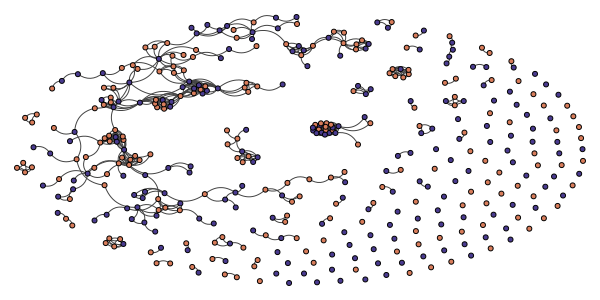

In [207]:
visual_style = {}

# Define colors used for gender visualization
colors = ['#4a3b90', '#d97d5b']
a.network.vs["color"] = [colors[0] if x == 'm' else colors[1] for x in a.network.vs['gender']]

# Set bbox and margin
visual_style["bbox"] = (600,300)
visual_style["margin"] = 17

# Set vertex size
visual_style["vertex_size"] = 5

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# curve the edges
visual_style["edge_curved"] = True

# Plot the graph
igraph.plot(a.network, **visual_style)